In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score

pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

## 1. Load Data & Perfrom Time-Based Split (V1 Graph Dataset)

In [2]:
df = pd.read_csv('../data/procressed/elliptic_bitcoin_dataset_v1_graph.csv')

# Rename 
df = df.rename(columns={'feat_0': 'time_step'})

if 'class' in df.columns:
    df = df.drop(columns=['class'])

# Test Set: Time 35-49
test_df = df[df['time_step'] > 34]

drop_cols = ['label', 'txId', 'time_step']
X_test = test_df.drop(columns=drop_cols)
y_test = test_df['label']

print(f"Test Set (Time 35-49): {X_test.shape}")
print(f"Test Target Distribution: {y_test.value_counts().to_dict()}")

Test Set (Time 35-49): (16670, 167)
Test Target Distribution: {0: 15587, 1: 1083}


## 2. Load Models (V1 Graph Models)

In [3]:
models_dir = '../models'
# Updated filenames for V1 Graph models
model_files = {
    "Logistic Regression": "logistic_regression_smote_v1_graph.pkl",
    "Random Forest": "random_forest_smote_v1_graph.pkl",
    "XGBoost": "xgboost_smote_v1_graph.pkl"
}

models = {}
for name, filename in model_files.items():
    path = os.path.join(models_dir, filename)
    if os.path.exists(path):
        with open(path, 'rb') as file:
            models[name] = pickle.load(file)
        print(f"Loaded {name}")
    else:
        print(f"Warning: {filename} not found!")

Loaded Logistic Regression
Loaded Random Forest
Loaded XGBoost


## 3. Evaluation

Evaluating Logistic Regression...
--- Logistic Regression Report ---
              precision    recall  f1-score   support

           0       0.99      0.77      0.87     15587
           1       0.20      0.84      0.33      1083

    accuracy                           0.78     16670
   macro avg       0.60      0.81      0.60     16670
weighted avg       0.93      0.78      0.83     16670



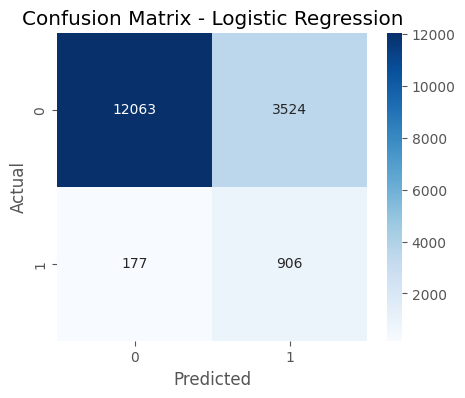

------------------------------
Evaluating Random Forest...
--- Random Forest Report ---
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     15587
           1       0.93      0.72      0.81      1083

    accuracy                           0.98     16670
   macro avg       0.95      0.86      0.90     16670
weighted avg       0.98      0.98      0.98     16670



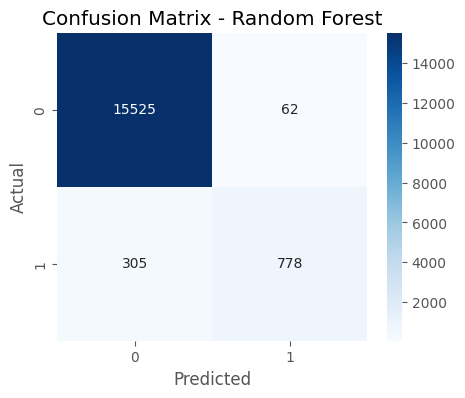

------------------------------
Evaluating XGBoost...
--- XGBoost Report ---
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     15587
           1       0.91      0.73      0.81      1083

    accuracy                           0.98     16670
   macro avg       0.94      0.86      0.90     16670
weighted avg       0.98      0.98      0.98     16670



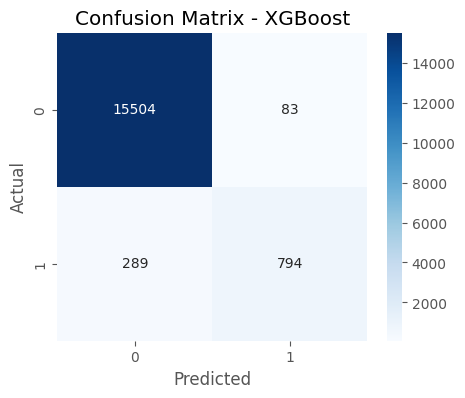

------------------------------


In [4]:
results = {}

for name, model in models.items():
    print(f"Evaluating {name}...")
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    
    results[name] = {
        "F1": f1,
        "Precision": prec,
        "Recall": rec,
        "AUC": auc
    }
    
    print(f"--- {name} Report ---")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    print("-"*30)

                           F1  Precision    Recall       AUC
XGBoost              0.810204   0.905359  0.733149  0.940867
Random Forest        0.809152   0.926190  0.718375  0.944972
Logistic Regression  0.328678   0.204515  0.836565  0.882660


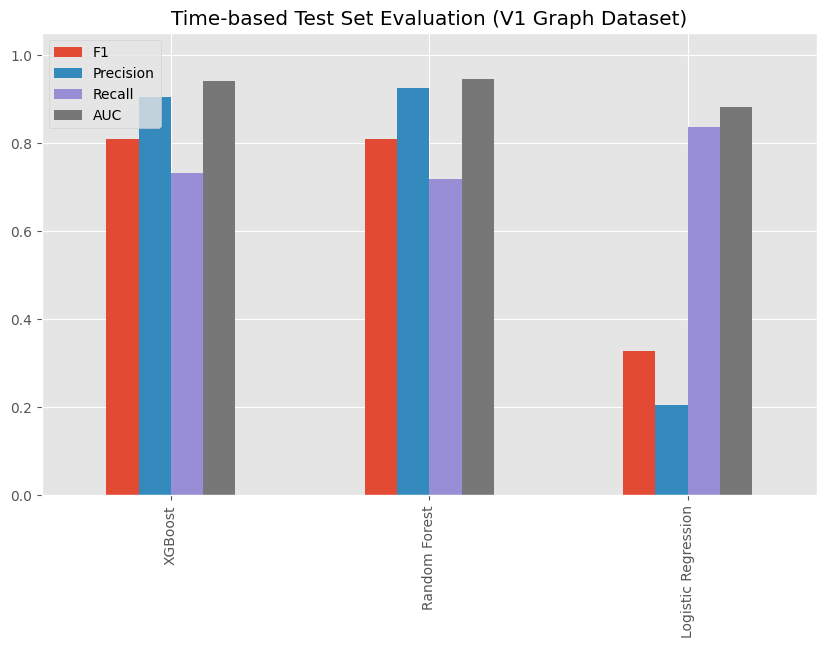

In [5]:
results_df = pd.DataFrame(results).T.sort_values(by='F1', ascending=False)
print(results_df)

results_df.plot(kind='bar', figsize=(10,6))
plt.title('Time-based Test Set Evaluation (V1 Graph Dataset)')
plt.ylim(0, 1.05)
plt.show()

## 4. Feature Importance

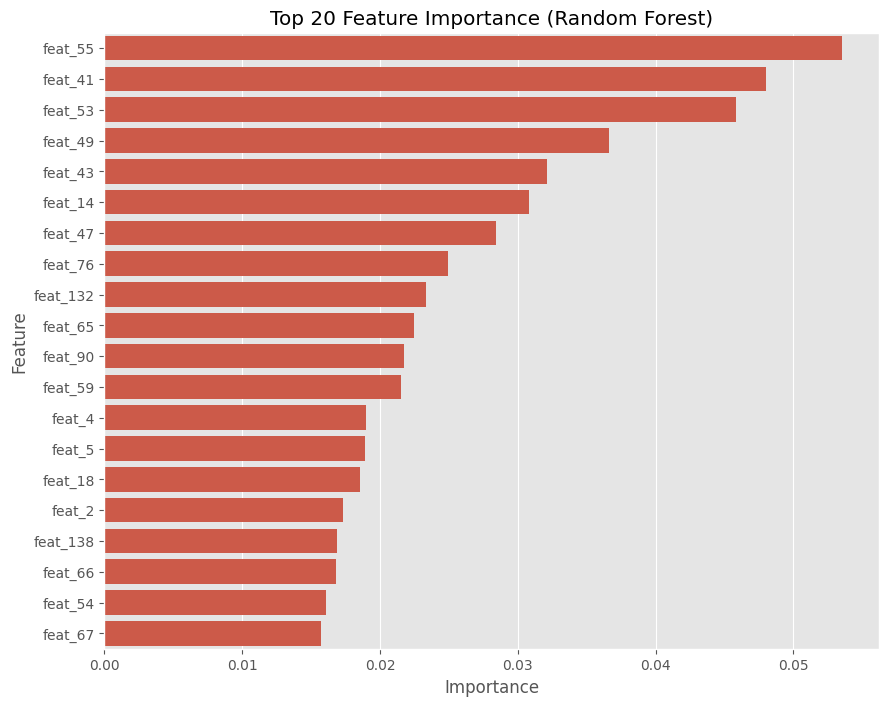

In [6]:
if "Random Forest" in models:
    rf_model = models["Random Forest"]
    importances = rf_model.feature_importances_
    feature_names = X_test.columns
    
    feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False).head(20)
    
    plt.figure(figsize=(10,8))
    sns.barplot(x='Importance', y='Feature', data=feature_imp_df)
    plt.title('Top 20 Feature Importance (Random Forest)')
    plt.show()